In [ ]:
## Written by Swati Kar

#Importing necessary packages
import os
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.utils import normalize

###Image Preprocessing

In [ ]:
#read the tif stack file
image_path = os.path.abspath('U_net_experiment_data/nanofiber_img/img_2/')
image_path

dirFiles = os.listdir(image_path)
# # dirFiles.sort()
# print(dirFiles)
image_list = []

for image in dirFiles:
    #print(image)
    if (image.split('.')[-1] == 'tif'):
        #print(image)
        full_path = image_path + '/' + image
        print(full_path)
        image_stack = tiff.imread(full_path)
        image_list.append(image_stack)

image_list[0].dtype.name

C:\Users\Swati\Desktop\Research\CellSegmentation\U_net_experiment_data\nanofiber_img\img_2/img_2.tif


'uint16'

In [ ]:
#one tif stack contains 73 frames
newImg = image_list[0]
newImg.shape

(73, 600, 800)

In [ ]:
#original image shape is 600X800
#patchfying image in 256X256 shape
#it will increase number of images for training
all_img_patches = []
for img in range(newImg.shape[0]):
    largeImg = newImg[img]
    patch_Img = patchify(largeImg,(256,256),step=64)
    
    for i in range(patch_Img.shape[0]):
        for j in range(patch_Img.shape[1]):
            single_patch_img = patch_Img[i,j,:,:]
#             tiff.imwrite('patches/images/'+'image_'+str(img)+'_'+str(i)+str(j)+'.tif',single_patch_img)
#             tiff.imwrite('U_net_experiment_data/all_images/new_patches_3Stack/new_patch_img/'+'image_'+str(img)+'_'+str(i)+str(j)+'.tif',single_patch_img)
#             tiff.imwrite('./patch_img_2/img/img_patch_256/'+'image_'+str(img)+'_'+str(i)+str(j)+'.tif',single_patch_img)

            single_patch_img = single_patch_img/np.max(single_patch_img)
            all_img_patches.append(single_patch_img)
all_img_patches[0].shape

(256, 256)

In [ ]:
all_img_patches[0].dtype.name

'float64'

In [ ]:
#expanding the last dimension that is color
images = np.array(all_img_patches)
train_images = np.expand_dims(images, axis=3)
train_images.shape

(3942, 256, 256, 1)

### Mask Preprocessing

In [ ]:
mask_path = 'U_net_experiment_data/nanofiber_img/mask_2'
mask_list = []
dirFiles = os.listdir(mask_path)
#print(dirFiles)

for image in dirFiles:
    if (image.split('.')[-1] == 'tiff'):
        full_path = mask_path + '/' + image
        print(full_path)
        mask_stack = tiff.imread(full_path)
        mask_list.append(mask_stack)

mask_list[0].dtype.name

U_net_experiment_data/nanofiber_img/mask_2/img_2_cell_predictions_process_predictions_background_predictions.ome (2).tiff


'uint8'

In [ ]:
newMask = mask_list[0]
newMask.shape

(73, 600, 800)

In [ ]:
all_mask_patches = []
for mask in range(newMask.shape[0]):
    largeMask = newMask[mask]
    patch_Mask = patchify(largeMask,(256,256),step=64)
    
    for i in range(patch_Mask.shape[0]):
        for j in range(patch_Mask.shape[1]):
            single_patch_mask = patch_Mask[i,j,:,:]
#             tiff.imwrite('patches/images/'+'image_'+str(img)+'_'+str(i)+str(j)+'.tif',single_patch_img)
#             tiff.imwrite('U_net_experiment_data/all_images/new_patches_3Stack/new_patch_img/'+'image_'+str(img)+'_'+str(i)+str(j)+'.tif',single_patch_img)
#             tiff.imwrite('./patch_img_2/mask/mask_patch_256/'+'mask_'+str(mask)+'_'+str(i)+str(j)+'.tif',single_patch_mask)

           # single_patch_mask = single_patch_mask/np.max(single_patch_mask)
            all_mask_patches.append(single_patch_mask)
all_mask_patches[0].shape

(256, 256)

In [ ]:
masks = np.array(all_mask_patches)
# images = np.expand_dims(images, -1)
masks.shape

(3942, 256, 256)

In [ ]:
masks.dtype.name

'uint8'

In [ ]:
#mask has total 3 unique classes: cell, process, background
np.unique(masks)

array([1, 2, 3], dtype=uint8)

In [ ]:
#It will shift the unique classes to 0,1,2
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape
train_masks_reshaped = masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

C:\Users\Swati\anaconda3\envs\test1\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2], dtype=int64)

In [ ]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
train_masks_input.shape

(3942, 256, 256, 1)

In [ ]:
train_masks_input.dtype.name

'int64'

In [ ]:
np.unique(train_masks_input)

array([0, 1, 2], dtype=int64)

In [ ]:
#splitting train and test images
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

In [ ]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2]


2920
2920


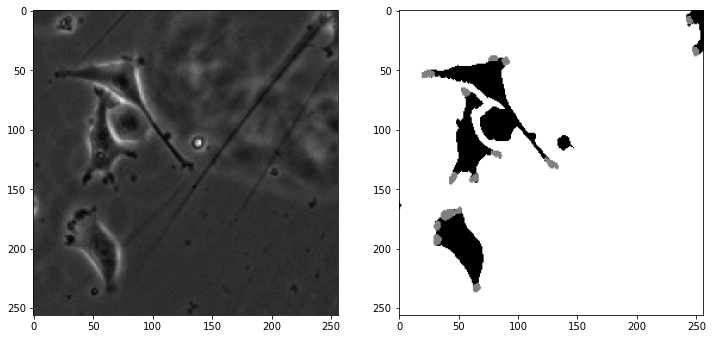

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
print(image_number)
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
print(image_number)
plt.show()

In [ ]:
SIZE_X = 256 
SIZE_Y = 256
n_classes=3

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


In [ ]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
#     model.summary()
    
    return model

In [ ]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

Epoch 1/5
222/222 [==============================] - 25s 106ms/step - loss: 0.1684 - accuracy: 0.9359 - val_loss: 0.0801 - val_accuracy: 0.9752
Epoch 2/5
222/222 [==============================] - 22s 97ms/step - loss: 0.0374 - accuracy: 0.9867 - val_loss: 0.0297 - val_accuracy: 0.9895
Epoch 3/5
222/222 [==============================] - 22s 98ms/step - loss: 0.0238 - accuracy: 0.9913 - val_loss: 0.0200 - val_accuracy: 0.9927
Epoch 4/5
222/222 [==============================] - 22s 98ms/step - loss: 0.0192 - accuracy: 0.9927 - val_loss: 0.0165 - val_accuracy: 0.9938
Epoch 5/5
222/222 [==============================] - 22s 99ms/step - loss: 0.0163 - accuracy: 0.9937 - val_loss: 0.0138 - val_accuracy: 0.9947


In [ ]:
model.save('multiclass_seg_model.h5')

In [ ]:
model.save('multiclass_seg_test.hdf5')

In [ ]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

13/13 [==============================] - 1s 54ms/step - loss: 0.0138 - accuracy: 0.9947
Accuracy is =  99.46659803390503 %


In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8676321


In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
#class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
#print("IoU for class4 is: ", class4_IoU)

[[1.0484360e+06 1.5490000e+04 5.9562000e+04 0.0000000e+00]
 [9.6830000e+03 1.2890200e+05 2.2627000e+04 0.0000000e+00]
 [2.4252000e+04 6.4640000e+03 1.6777216e+07 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
IoU for class1 is:  0.9058365
IoU for class2 is:  0.7037442
IoU for class3 is:  0.9933154


In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

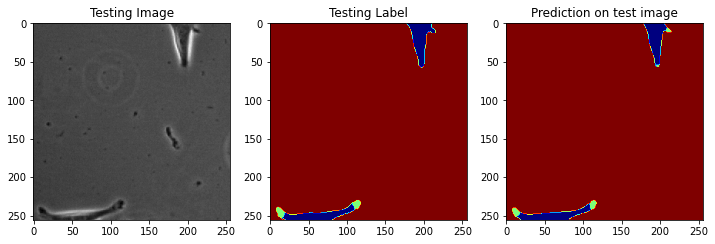

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()